In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import text
import os

# Week X data

In [2]:
##Importing weekly player data

week = 12

players_df = pd.read_csv(f"salaries/Week{week}_salaries_rotowire.csv")
players_df ['dk_salary'] = players_df ['salary'].astype('float')
players_df ['fantasy_score'] = players_df ['proj_points'].astype('float')
players_df ['player'] = players_df ['player']
players_df ['pos'] = players_df ['position']
players_df = players_df[['player','pos','dk_salary','fantasy_score']]


In [3]:
players_df

,player,pos,dk_salary,fantasy_score
0,Tyler Shough,QB,4400.0,16.82
1,Jalen Hurts,QB,6600.0,24.05
2,Lamar Jackson,QB,6700.0,23.93
3,Aaron Rodgers,QB,5200.0,18.83
4,Kirk Cousins,QB,4400.0,15.22
...,...,...,...,...
552,DeAndre Carter,WR,3000.0,0.00
553,Eric Saubert,TE,2500.0,0.00
554,Malik Nabers,WR,3000.0,0.00
555,Zavier Scott,RB,4000.0,0.16


0.5430638249124476
0.5430638249124495


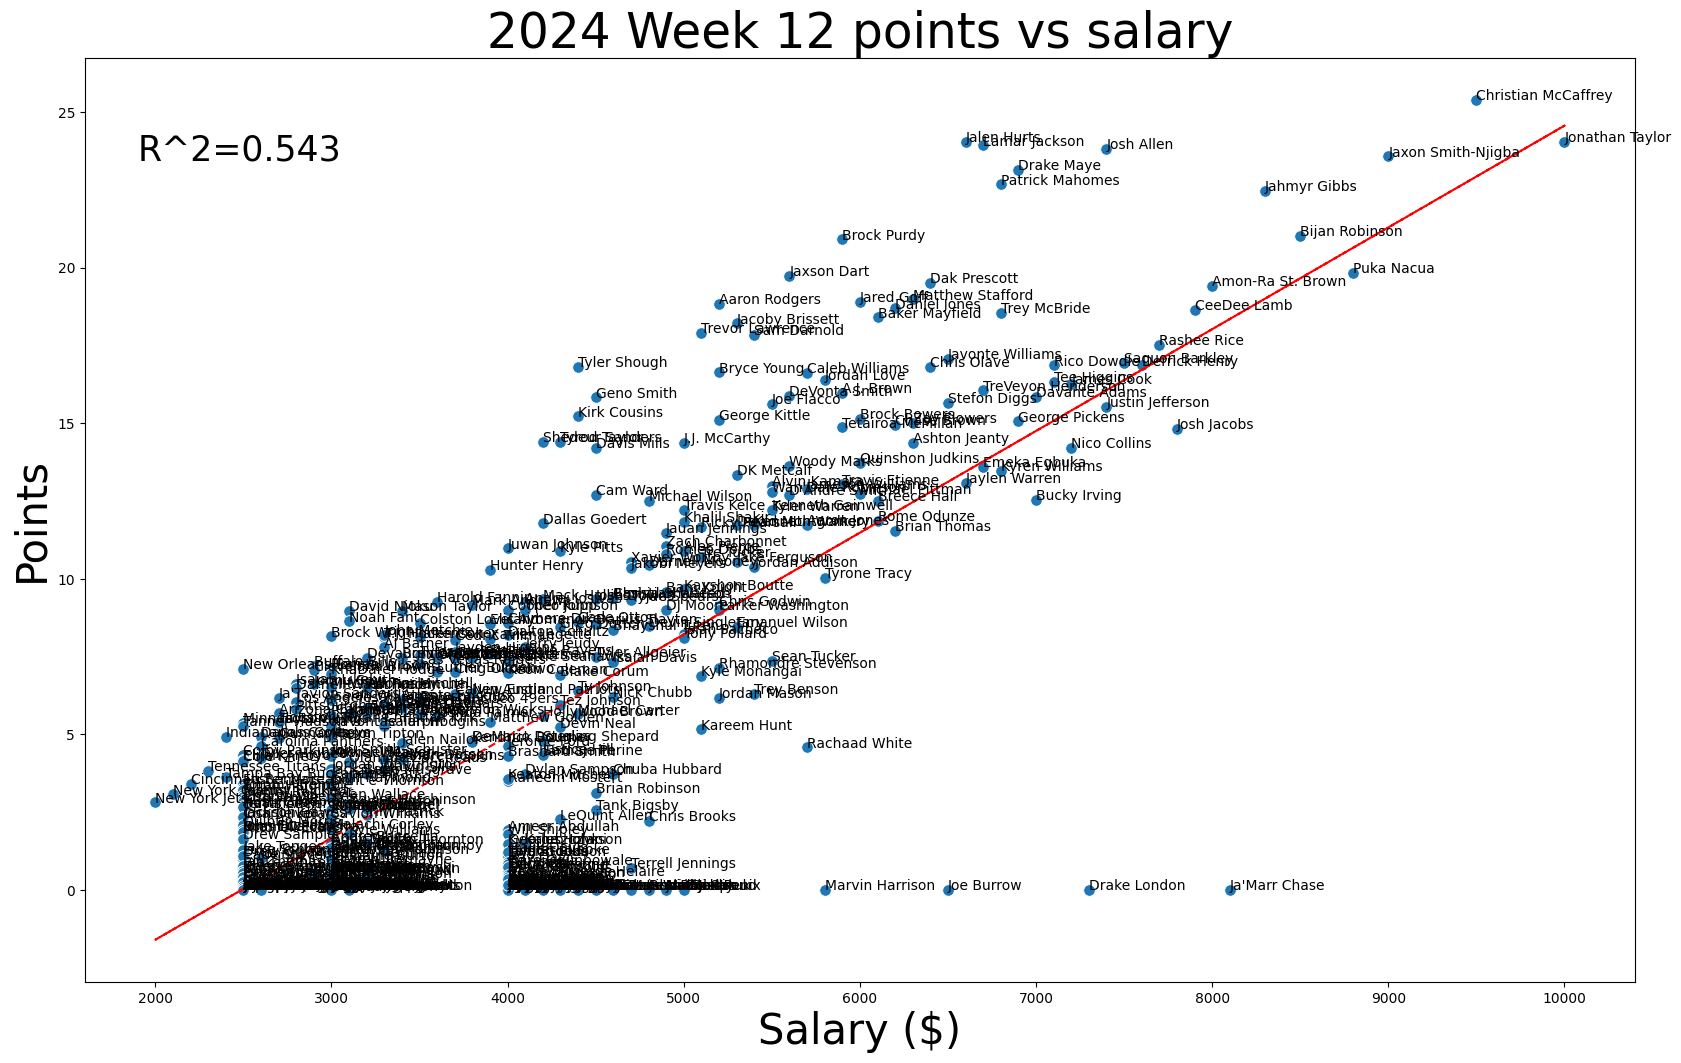

In [4]:
##Plot Points vs Salary, linear trend
x = players_df['dk_salary']
y = players_df['fantasy_score']

z, res, _, _, _ = np.polyfit(x, y, 1, full = True)
p = np.poly1d(z)

##R^2 value
yhat =   [p(z) for z in x]       # or [p(z) for z in x]
ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
r2 = (ssreg / sstot)
print(r2)

#r^2 value another way
SSE = res[0]
diff = y - y.mean()
square_diff = diff **2
SST = square_diff.sum()
r2 = 1 - SSE/SST
print(r2)

fig, ax = plt.subplots(figsize=(20,12))
sns.scatterplot(ax=ax,x='dk_salary',y='fantasy_score',data=players_df,s=70)

plt.title(f'2024 Week {week} points vs salary',fontsize=35)
plt.xlabel('Salary ($)',fontsize=30)
plt.ylabel('Points',fontsize=30)

plt.plot(x,p(x),"r--")

for i,name in enumerate(players_df['player']):
    ax.annotate(name,(x[i],y[i]))

text(0.1, 0.9,'R^2={}'.format('%.3f'%(r2)),fontsize=25,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
    
plt.show()

In [5]:
##Seeing which players are above or below trend line
players_df['trend y'] = p(players_df['dk_salary'])
players_df['trend diff'] = players_df['fantasy_score'] - players_df['trend y']

better_players_df = players_df[players_df['trend diff'] > 0]
# better_players_df = better_players_df.sort_values(by=['fantasy_score'],ascending=False)
better_players_df = better_players_df.sort_values(by=['trend diff'],ascending=False)
better_players_df = better_players_df[['player','pos','dk_salary','fantasy_score','trend diff']]

In [6]:
better_players_df

,player,pos,dk_salary,fantasy_score,trend diff
1,Jalen Hurts,QB,6600.0,24.05,10.605669
0,Tyler Shough,QB,4400.0,16.82,10.571720
2,Lamar Jackson,QB,6700.0,23.93,10.158576
3,Aaron Rodgers,QB,5200.0,18.83,9.964974
6,Brock Purdy,QB,5900.0,20.91,9.755321
...,...,...,...,...,...
445,Ben Yurosek,TE,2500.0,0.10,0.066492
160,Rome Odunze,WR,6100.0,11.86,0.051135
207,Tez Johnson,WR,4300.0,5.95,0.028813
549,Will Mallory,TE,2500.0,0.05,0.016492


# Make Picks

In [7]:
positions_needed = {
    'QB': 1,
    'RB': 2,
    'WR': 3,
    'TE': 1,
    'DST': 1,
    'FLEX': 1
    }

picks_df = pd.DataFrame(columns = ['player','pos','dk_salary','fantasy_score'])

total_salary = 50000


In [8]:
#Pick best 1 RB, and 1 WR available
best_rb = better_players_df[better_players_df['pos'] == 'RB'].head(1)
best_rb  = best_rb.drop('trend diff',axis=1)
best_wr = better_players_df[better_players_df['pos'] == 'WR'].head(1)
best_wr  = best_wr.drop('trend diff',axis=1)
picks_df = pd.concat([picks_df,best_rb,best_wr])

remaining_salary = total_salary - picks_df['dk_salary'].sum()
remaining_salary

/var/folders/44/11jmwyzd3tz_crgr6qx_9z_w0000gp/T/ipykernel_7248/2988056733.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  picks_df = pd.concat([picks_df,best_rb,best_wr])


np.float64(37900.0)

In [9]:
picks_df

,player,pos,dk_salary,fantasy_score
44,Javonte Williams,RB,6500.0,17.07
27,DeVonta Smith,WR,5600.0,15.89


In [10]:
#Best per dollar
better_per_dollar_players_df = better_players_df.copy()
better_per_dollar_players_df['point_per_dollar'] = better_per_dollar_players_df['fantasy_score'] / better_per_dollar_players_df['dk_salary']
better_per_dollar_players_df = better_per_dollar_players_df.sort_values(by=['point_per_dollar'],ascending=False)

In [11]:
better_per_dollar_players_df

,player,pos,dk_salary,fantasy_score,trend diff,point_per_dollar
0,Tyler Shough,QB,4400.0,16.82,10.571720,0.003823
1,Jalen Hurts,QB,6600.0,24.05,10.605669,0.003644
3,Aaron Rodgers,QB,5200.0,18.83,9.964974,0.003621
2,Lamar Jackson,QB,6700.0,23.93,10.158576,0.003572
6,Brock Purdy,QB,5900.0,20.91,9.755321,0.003544
...,...,...,...,...,...,...
355,Devin Culp,TE,2500.0,0.12,0.086492,0.000048
349,Josiah Deguara,TE,2500.0,0.12,0.086492,0.000048
459,Jelani Woods,TE,2500.0,0.11,0.076492,0.000044
445,Ben Yurosek,TE,2500.0,0.10,0.066492,0.000040


In [12]:
# Pick best value QB
best_qb = better_per_dollar_players_df[better_per_dollar_players_df['pos'] == 'QB'].head(1)
best_qb = best_qb.drop(['point_per_dollar','trend diff'], axis=1)
picks_df = pd.concat([picks_df,best_qb])

remaining_salary = total_salary - picks_df['dk_salary'].sum()
remaining_salary

np.float64(33500.0)

In [13]:
# Pick next best two value RBs
best_rb = better_per_dollar_players_df[better_per_dollar_players_df['pos'] == 'RB']
best_rb  = best_rb.drop(['point_per_dollar','trend diff'], axis=1)
for i in range(2):
    for index, row in best_rb.iterrows():
        if row['player'] not in picks_df['player'].values:
            print(row['player'])
            picks_df = pd.concat([picks_df,row.to_frame().T])
            break

Jahmyr Gibbs
Christian McCaffrey


In [14]:
picks_df

,player,pos,dk_salary,fantasy_score
44,Javonte Williams,RB,6500.0,17.07
27,DeVonta Smith,WR,5600.0,15.89
0,Tyler Shough,QB,4400.0,16.82
36,Jahmyr Gibbs,RB,8300.0,22.47
38,Christian McCaffrey,RB,9500.0,25.4


In [15]:
total_salary - picks_df['dk_salary'].sum()

15700.0

In [16]:
# Pick next best two value WRs that cost 1/4 or less than remaining salary
best_wr = better_per_dollar_players_df[better_per_dollar_players_df['pos'] == 'WR']
best_wr  = best_wr.drop(['point_per_dollar','trend diff'], axis=1)
remaining_salary = total_salary - picks_df['dk_salary'].sum()
for i in range(2):
    for index, row in best_wr.iterrows():
        if row['player'] not in picks_df['player'].values and row['dk_salary'] <= remaining_salary/4:
            print(row['player'])
            picks_df = pd.concat([picks_df,row.to_frame().T])
            break

John Metchie
Roman Wilson


In [17]:
#Pick best DST if possible
best_dst = better_per_dollar_players_df[better_per_dollar_players_df['pos'] ==  'D'].head(1)
best_dst = best_dst.drop(['trend diff','point_per_dollar'],axis=1)
picks_df = pd.concat([picks_df,best_dst])

In [18]:
best_dst

,player,pos,dk_salary,fantasy_score
32,New Orleans Saints,D,2500.0,7.1


In [19]:
#Pick best TE I can afford
best_te = better_per_dollar_players_df[better_per_dollar_players_df['pos'] ==  'TE']
best_te = best_te.drop(['point_per_dollar','trend diff'], axis=1)
remaining_salary = total_salary - picks_df['dk_salary'].sum()
for index, row in best_te.iterrows():
    if row['dk_salary'] <= remaining_salary:
        print(row['player'])
        picks_df = pd.concat([picks_df,row.to_frame().T])
        break

George Kittle


In [20]:
best_te

,player,pos,dk_salary,fantasy_score
23,George Kittle,TE,5200.0,15.12
25,David Njoku,TE,3100.0,8.98
29,Dallas Goedert,TE,4200.0,11.78
31,Noah Fant,TE,3100.0,8.63
39,Juwan Johnson,TE,4000.0,10.98
...,...,...,...,...
355,Devin Culp,TE,2500.0,0.12
349,Josiah Deguara,TE,2500.0,0.12
459,Jelani Woods,TE,2500.0,0.11
445,Ben Yurosek,TE,2500.0,0.10


In [21]:
picks_df

,player,pos,dk_salary,fantasy_score
44,Javonte Williams,RB,6500.0,17.07
27,DeVonta Smith,WR,5600.0,15.89
0,Tyler Shough,QB,4400.0,16.82
36,Jahmyr Gibbs,RB,8300.0,22.47
38,Christian McCaffrey,RB,9500.0,25.4
51,John Metchie,WR,3300.0,8.19
62,Roman Wilson,WR,3000.0,7.1
32,New Orleans Saints,D,2500.0,7.1
23,George Kittle,TE,5200.0,15.12


In [22]:
total_salary - picks_df['dk_salary'].sum()

1700.0

In [23]:
# Use remaining salary to reinvest into most expensive QB
pick_qb_price = picks_df[picks_df['pos'] == 'QB']['dk_salary'].values[0]
remaining_salary = total_salary - picks_df['dk_salary'].sum()

# pick_qb_price
qbs = better_players_df[better_players_df['pos'] == 'QB']
new_qb = qbs[qbs['dk_salary'] <= remaining_salary + pick_qb_price].sort_values('dk_salary',ascending=False).head(1)
new_qb = new_qb.drop('trend diff',axis=1)

# remove old qb add new qb
picks_df = picks_df[picks_df['pos'] != 'QB']
picks_df = pd.concat([picks_df,new_qb])


In [24]:
picks_df

,player,pos,dk_salary,fantasy_score
44,Javonte Williams,RB,6500.0,17.07
27,DeVonta Smith,WR,5600.0,15.89
36,Jahmyr Gibbs,RB,8300.0,22.47
38,Christian McCaffrey,RB,9500.0,25.4
51,John Metchie,WR,3300.0,8.19
62,Roman Wilson,WR,3000.0,7.1
32,New Orleans Saints,D,2500.0,7.1
23,George Kittle,TE,5200.0,15.12
20,Baker Mayfield,QB,6100.0,18.4


In [25]:
total_salary - picks_df['dk_salary'].sum()

0.0

In [26]:
# Use remaining salary to replace cheapest WR with more expensive WR
pick_wr_price = picks_df[picks_df['pos'] == 'WR']['dk_salary'].values.min()
remaining_salary = total_salary - picks_df['dk_salary'].sum()

# pick_wr_price
wrs = better_players_df[better_players_df['pos'] == 'WR']
new_wr = wrs[wrs['dk_salary'] <= remaining_salary + pick_wr_price].sort_values('dk_salary',ascending=False).head(1)
new_wr = new_wr.drop('trend diff',axis=1)

old_wr = picks_df[picks_df['dk_salary'] == pick_wr_price]
print(old_wr)
print(new_wr)

# remove old wr add new wr
picks_df = picks_df.drop(old_wr.index)
picks_df = pd.concat([picks_df,new_wr])

          player pos dk_salary fantasy_score
62  Roman Wilson  WR    3000.0           7.1
          player pos  dk_salary  fantasy_score
62  Roman Wilson  WR     3000.0            7.1


In [27]:
picks_df = picks_df.drop('fantasy_score',axis=1)
picks_df = picks_df.rename(columns={'dk_salary':'salary'})

In [28]:
picks_df

,player,pos,salary
44,Javonte Williams,RB,6500.0
27,DeVonta Smith,WR,5600.0
36,Jahmyr Gibbs,RB,8300.0
38,Christian McCaffrey,RB,9500.0
51,John Metchie,WR,3300.0
32,New Orleans Saints,D,2500.0
23,George Kittle,TE,5200.0
20,Baker Mayfield,QB,6100.0
62,Roman Wilson,WR,3000.0


In [29]:
picks_df.to_csv(f'picks/antonio_trani_week{week}_picks.csv',index=False)